In [1]:
%%cmd
pip install "C:\Users\user\anaconda3\Dlib_Windows_Python3.x-main\dlib-19.24.99-cp312-cp312-win_amd64.whl"

Microsoft Windows [Version 10.0.19045.5131]
(c) Microsoft Corporation. All rights reserved.

(base) C:\Users\user\anaconda3\Major Project\gaze detection>pip install "C:\Users\user\anaconda3\Dlib_Windows_Python3.x-main\dlib-19.24.99-cp312-cp312-win_amd64.whl"
Processing c:\users\user\anaconda3\dlib_windows_python3.x-main\dlib-19.24.99-cp312-cp312-win_amd64.whl
dlib is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.

(base) C:\Users\user\anaconda3\Major Project\gaze detection>

In [ ]:
'''Implementing SVM (Support Vector Machines) Model'''

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed, dump, load

def process_image(file_path, label, target_size=(50, 50)):
    try:
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, target_size)
            return image.flatten(), label
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    return None, None

# Function to load and preprocess images in parallel
def load_images_parallel(path, target_size=(50, 50)):
    images, labels = [], []
    label_map = {
        "TopLeft": 0,
        "TopCenter": 1,
        "TopRight": 2,
        "MiddleLeft": 3,
        "MiddleRight": 4,
        "BottomLeft": 5,
        "BottomCenter": 6,
        "BottomRight": 7
    }

    for folder in tqdm(os.listdir(path), desc="Processing folders"):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            label = label_map.get(folder, -1)
            if label != -1:
                file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
                results = Parallel(n_jobs=-1)(
                    delayed(process_image)(file_path, label, target_size) for file_path in file_paths
                )
                for img, lbl in results:
                    if img is not None:
                        images.append(img)
                        labels.append(lbl)
    return np.array(images), np.array(labels)

data_path = r"C:\Users\user\anaconda3\Major Project\gaze detection\Data for model\Training\TrainingSet"

dataset_file = 'preprocessed_dataset.npz'
if os.path.exists(dataset_file):
    print("Loading preprocessed dataset...")
    data = np.load(dataset_file)
    X, y = data['images'], data['labels']
else:
    print("Loading and preprocessing dataset...")
    X, y = load_images_parallel(data_path, target_size=(50, 50))
    np.savez_compressed(dataset_file, images=X, labels=y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Reducing dimensionality using PCA...")
pca_file = 'pca_model.joblib'
if os.path.exists(pca_file):
    pca = load(pca_file)
    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)
else:
    pca = PCA(n_components=0.90)  # Retain 90% variance
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    dump(pca, pca_file)

print("Training the SVM classifier...")
svm_file = 'svm_model.joblib'
if os.path.exists(svm_file):
    svm = load(svm_file)
else:
    svm = LinearSVC(max_iter=10000)
    svm.fit(X_train_pca, y_train)
    dump(svm, svm_file)

print("Evaluating the classifier...")
y_pred = svm.predict(X_val_pca)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")


Loading and preprocessing dataset...


Processing folders: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:59<00:00,  7.40s/it]


Reducing dimensionality using PCA...
Training the SVM classifier...
Evaluating the classifier...
Validation Accuracy: 0.80


In [5]:
from joblib import dump
dump(svm, 'svm_model_eye.joblib')

['svm_model_eye.joblib']

In [ ]:
'''Implementing CNN (Convolution Neural Network)'''

In [34]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def process_image(file_path, label, target_size=(50, 50)):
    try:
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, target_size)
            return image, label
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    return None, None

def load_images(path, target_size=(50, 50)):
    images, labels = [], []
    label_map = {
        "TopLeft": 0, "TopCenter": 1, "TopRight": 2,
        "MiddleLeft": 3, "MiddleRight": 4,
        "BottomLeft": 5, "BottomCenter": 6, "BottomRight": 7
    }

    for folder in tqdm(os.listdir(path), desc="Processing folders"):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            label = label_map.get(folder, -1)
            if label != -1:
                for file in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file)
                    img, lbl = process_image(file_path, label, target_size)
                    if img is not None:
                        images.append(img)
                        labels.append(lbl)

    images = np.array(images, dtype=np.float32) / 255.0  # Normalize
    labels = np.array(labels)
    return images, labels

data_path = r"C:\Users\user\anaconda3\Major Project\gaze detection\Data for model\Training\TrainingSet"
print("Loading dataset...")
X, y = load_images(data_path, target_size=(50, 50))

X_reshaped = X.reshape(-1, 50, 50, 1)
y_onehot = to_categorical(y, num_classes=8)

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_onehot, test_size=0.2, random_state=42)

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("Training CNN model...")
cnn_model = create_cnn_model()
cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

cnn_loss, cnn_accuracy = cnn_model.evaluate(X_val, y_val, verbose=0)
print(f"CNN Accuracy: {cnn_accuracy:.2f}")

cnn_model.save('cnn_model_eye.h5')
print("\nSummary of Model Performance:")
print(f"CNN Accuracy: {cnn_accuracy:.2f}")




Loading dataset...


Processing folders: 100%|████████████████████████████████████████████████████████████████| 8/8 [02:10<00:00, 16.34s/it]


Training CNN model...
Epoch 1/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 68s 36ms/step - accuracy: 0.7397 - loss: 0.6793 - val_accuracy: 0.9122 - val_loss: 0.2094
Epoch 2/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 66s 36ms/step - accuracy: 0.9021 - loss: 0.2440 - val_accuracy: 0.9226 - val_loss: 0.1798
Epoch 3/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.9166 - loss: 0.2066 - val_accuracy: 0.9290 - val_loss: 0.1677
Epoch 4/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 66s 36ms/step - accuracy: 0.9263 - loss: 0.1840 - val_accuracy: 0.9361 - val_loss: 0.1515
Epoch 5/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 66s 36ms/step - accuracy: 0.9312 - loss: 0.1711 - val_accuracy: 0.9317 - val_loss: 0.1549
Epoch 6/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 66s 36ms/step - accuracy: 0.9357 - loss: 0.1635 - val_accuracy: 0.9335 - val_loss: 0.1520
Epoch 7/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/step - accuracy: 0.9373 - loss: 0.1562 - val_accuracy: 0.9367 - val_loss: 0.1454
Epoch 8/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/ste

CNN Accuracy: 0.94

Summary of Model Performance:
CNN Accuracy: 0.94


In [ ]:
'''Implementing Random Forest '''

In [15]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def preprocess_images(data_dir, label_map, target_size=(32, 32)):
    images, labels = [], []
    for label, class_name in label_map.items():
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"Directory {class_dir} does not exist. Skipping...")
            continue
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            try:
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    continue
                image = cv2.resize(image, target_size)
                images.append(image.flatten())  # Flatten the image into a feature vector
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    return np.array(images), np.array(labels)

label_map = {
    0: "TopLeft", 1: "TopCenter", 2: "TopRight",
    3: "MiddleLeft", 4: "MiddleRight",
    5: "BottomLeft", 6: "BottomCenter", 7: "BottomRight"
}

data_dir = r"C:\Users\user\anaconda3\Major Project\gaze detection\Data for model\Training\TrainingSet"
X, y = preprocess_images(data_dir, label_map)

unique_classes, counts = np.unique(y, return_counts=True)
print(f"Class Distribution: {dict(zip(unique_classes, counts))}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=50, random_state=42)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_features='sqrt',  
    max_depth=10,  
    random_state=42,
    n_jobs=-1  
)
rf_model.fit(X_train_pca, y_train)
rf_predictions = rf_model.predict(X_test_pca)

bagging_model = BaggingClassifier(
    estimator=RandomForestClassifier(
        n_estimators=50,
        max_features='sqrt',
        max_depth=8,
        random_state=42,
        n_jobs=-1
    ),
    n_estimators=10,  
    random_state=42,
    n_jobs=-1
)
bagging_model.fit(X_train_pca, y_train)
bagging_predictions = bagging_model.predict(X_test_pca)


from sklearn.ensemble import AdaBoostClassifier

boosting_model = AdaBoostClassifier(
    estimator=RandomForestClassifier(
        n_estimators=20,
        max_depth=5,
        random_state=42
    ),
    n_estimators=50,
    learning_rate=0.5,
    random_state=42
)
boosting_model.fit(X_train_pca, y_train)
boosting_predictions = boosting_model.predict(X_test_pca)


print("Random Forest Classifier:")
print(classification_report(y_test, rf_predictions))
print(f"Accuracy: {accuracy_score(y_test, rf_predictions)}\n")

print("Bagging with Random Forest:")
print(classification_report(y_test, bagging_predictions))
print(f"Accuracy: {accuracy_score(y_test, bagging_predictions)}\n")

print("Boosting with AdaBoost (Random Forest):")
print(classification_report(y_test, boosting_predictions))
print(f"Accuracy: {accuracy_score(y_test, boosting_predictions)}\n")


Class Distribution: {0: 9202, 1: 6857, 2: 9292, 3: 10911, 4: 11029, 5: 9151, 6: 6807, 7: 9251}


C:\Users\user\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58      1841
           1       0.52      0.25      0.34      1372
           2       0.58      0.54      0.56      1858
           3       0.52      0.63      0.57      2182
           4       0.54      0.69      0.60      2206
           5       0.49      0.59      0.54      1830
           6       0.44      0.12      0.19      1361
           7       0.49      0.56      0.52      1850

    accuracy                           0.53     14500
   macro avg       0.52      0.50      0.49     14500
weighted avg       0.52      0.53      0.51     14500

Accuracy: 0.5253793103448275

Bagging with Random Forest:
              precision    recall  f1-score   support

           0       0.54      0.57      0.55      1841
           1       0.50      0.17      0.26      1372
           2       0.56      0.51      0.53      1858
           3       0.48      0.63      0.55     

In [ ]:
'''So out of the three models CNN  classifier gave highest accuracy on provided dataset. 
So we will use CNN as out final model for making predictions'''

Loading dataset...


Processing folders: 100%|████████████████████████████████████████████████████████████████| 8/8 [02:15<00:00, 16.91s/it]


Training CNN model...
Epoch 1/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 77s 38ms/step - accuracy: 0.7199 - loss: 0.7198 - val_accuracy: 0.9166 - val_loss: 0.2026
Epoch 2/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/step - accuracy: 0.9059 - loss: 0.2359 - val_accuracy: 0.9258 - val_loss: 0.1766
Epoch 3/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.9216 - loss: 0.1956 - val_accuracy: 0.9274 - val_loss: 0.1667
Epoch 4/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.9271 - loss: 0.1797 - val_accuracy: 0.9303 - val_loss: 0.1596
Epoch 5/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/step - accuracy: 0.9302 - loss: 0.1730 - val_accuracy: 0.9346 - val_loss: 0.1525
Epoch 6/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 66s 36ms/step - accuracy: 0.9337 - loss: 0.1608 - val_accuracy: 0.9331 - val_loss: 0.1514
Epoch 7/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.9383 - loss: 0.1520 - val_accuracy: 0.9377 - val_loss: 0.1442
Epoch 8/20
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/ste

CNN Accuracy: 0.94


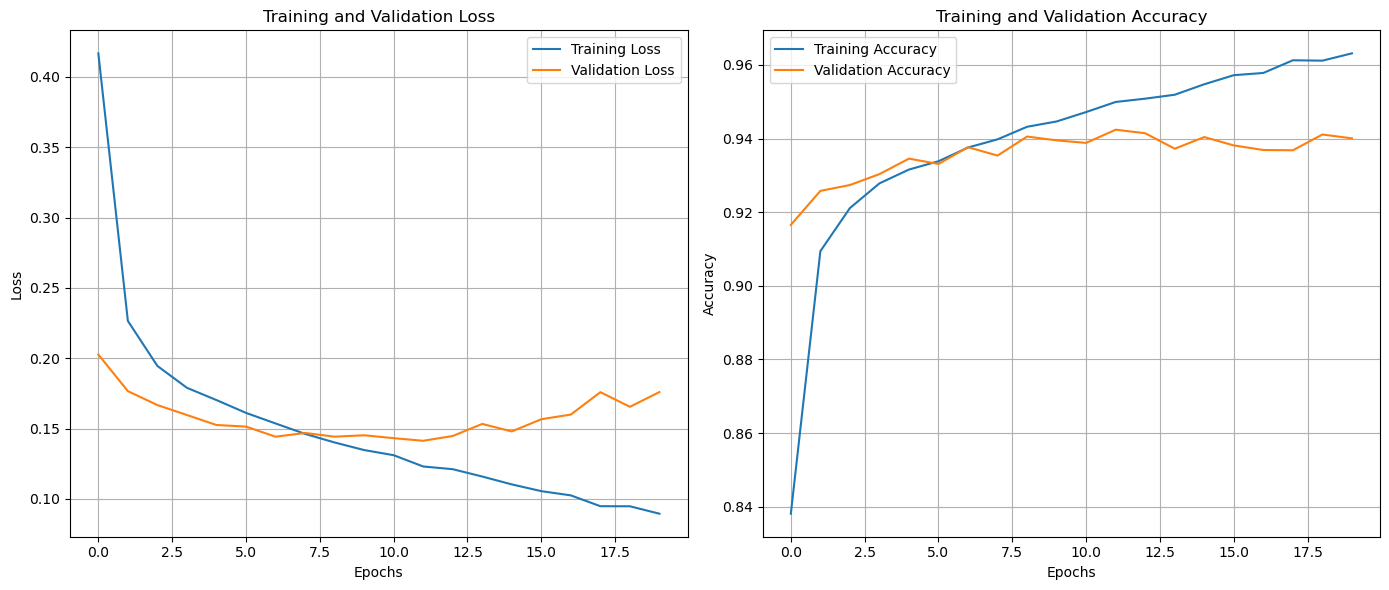

In [32]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

def process_image(file_path, label, target_size=(50, 50)):
    try:
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, target_size)
            return image, label
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    return None, None

def load_images(path, target_size=(50, 50)):
    images, labels = [], []
    label_map = {
        "TopLeft": 0, "TopCenter": 1, "TopRight": 2,
        "MiddleLeft": 3, "MiddleRight": 4,
        "BottomLeft": 5, "BottomCenter": 6, "BottomRight": 7
    }

    for folder in tqdm(os.listdir(path), desc="Processing folders"):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            label = label_map.get(folder, -1)
            if label != -1:
                for file in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file)
                    img, lbl = process_image(file_path, label, target_size)
                    if img is not None:
                        images.append(img)
                        labels.append(lbl)

    images = np.array(images, dtype=np.float32) / 255.0  
    labels = np.array(labels)
    return images, labels

data_path = r"C:\Users\user\anaconda3\Major Project\gaze detection\Data for model\Training\TrainingSet"
print("Loading dataset...")
X, y = load_images(data_path, target_size=(50, 50))

X_reshaped = X.reshape(-1, 50, 50, 1)
y_onehot = to_categorical(y, num_classes=8)

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_onehot, test_size=0.2, random_state=42)

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("Training CNN model...")
cnn_model = create_cnn_model()
history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

cnn_loss, cnn_accuracy = cnn_model.evaluate(X_val, y_val, verbose=0)
print(f"CNN Accuracy: {cnn_accuracy:.2f}")

cnn_model.save('cnn_model_eye.h5')

# Plotting Loss and Accuracy
def plot_loss_accuracy(history):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history)


Loading test dataset...


Processing folders: 100%|████████████████████████████████████████████████████████████████| 8/8 [04:26<00:00, 33.33s/it]


Shape of X_test_reshaped: (132630, 50, 50, 1)


4145/4145 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step


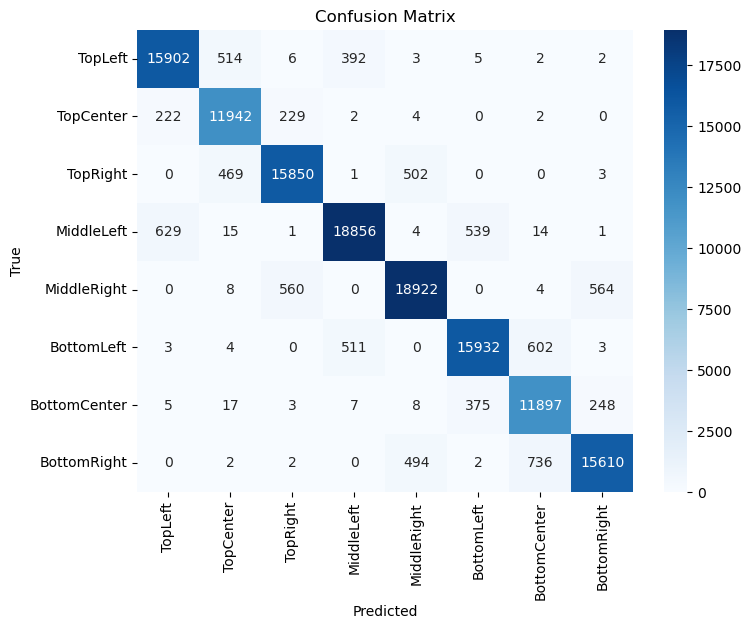

Classification Report:
              precision    recall  f1-score   support

     TopLeft       0.95      0.95      0.95     16826
   TopCenter       0.92      0.96      0.94     12401
    TopRight       0.95      0.94      0.95     16825
  MiddleLeft       0.95      0.94      0.95     20059
 MiddleRight       0.95      0.94      0.95     20058
  BottomLeft       0.95      0.93      0.94     17055
BottomCenter       0.90      0.95      0.92     12560
 BottomRight       0.95      0.93      0.94     16846

    accuracy                           0.94    132630
   macro avg       0.94      0.94      0.94    132630
weighted avg       0.94      0.94      0.94    132630



In [25]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import os
from tqdm import tqdm

label_map = {
    0: "TopLeft", 1: "TopCenter", 2: "TopRight",
    3: "MiddleLeft", 4: "MiddleRight", 
    5: "BottomLeft", 6: "BottomCenter", 7: "BottomRight"
}

def process_image(file_path, label, target_size=(50, 50)):
    try:
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, target_size)
            return image, label
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    return None, None

def load_images(path, target_size=(50, 50)):
    images, labels = [], []
    label_map = {
        "TopLeft": 0, "TopCenter": 1, "TopRight": 2,
        "MiddleLeft": 3, "MiddleRight": 4, "BottomLeft": 5, "BottomCenter": 6, "BottomRight": 7
    }

    for folder in tqdm(os.listdir(path), desc="Processing folders"):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            label = label_map.get(folder, -1)
            if label != -1:
                for file in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file)
                    img, lbl = process_image(file_path, label, target_size)
                    if img is not None:
                        images.append(img)
                        labels.append(lbl)

    images = np.array(images, dtype=np.float32) / 255.0  # Normalize
    labels = np.array(labels)
    return images, labels

data_path = r"C:\Users\user\anaconda3\Major Project\gaze detection\Data for model\Testing\TestingSet\TestSet\TestSet"
print("Loading test dataset...")
X_test, y_test = load_images(data_path, target_size=(50, 50))

X_test_reshaped = X_test.reshape(-1, 50, 50, 1)
y_test_onehot = to_categorical(y_test, num_classes=8)

print(f"Shape of X_test_reshaped: {X_test_reshaped.shape}")

cnn_model = load_model('cnn_model_eye.h5')

y_pred = cnn_model.predict(X_test_reshaped)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_onehot, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_map.values()))


In [11]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

def preprocess_image(image_path, target_size=(50, 50)):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError("Image not found or invalid format.")
        
        image = cv2.resize(image, target_size)
        image = image / 255.0  # Normalize pixel values
        return image.reshape(1, target_size[0], target_size[1], 1)
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

def predict_gaze_from_image(image_path):
    cnn_model = load_model('cnn_model_eye.h5')
    label_map = {
        0: "TopLeft", 1: "TopCenter", 2: "TopRight",
        3: "MiddleLeft", 4: "MiddleRight",
        5: "BottomLeft", 6: "BottomCenter", 7: "BottomRight"
    }

    preprocessed_image = preprocess_image(image_path)
    if preprocessed_image is None:
        return "Error in preprocessing image."

    prediction = cnn_model.predict(preprocessed_image)
    predicted_label = label_map[np.argmax(prediction)]

    return predicted_label


if __name__ == "__main__":
    image_path = r"C:\Users\user\anaconda3\Major Project\gaze detection\Data for model\Testing\TestingSet\74.jpg" 
    result = predict_gaze_from_image(image_path)
    print(f"Predicted Gaze Direction: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
Predicted Gaze Direction: TopLeft
